<a href="https://colab.research.google.com/github/santolina/Tensorflow-Dev/blob/master/Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 %tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import glob
import os
import math
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.0.0'

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# move colab notebooks
#%cd ~/
#%cd /content/drive
#%cd My\ Drive
#%cd Colab\ Notebooks

%cd /content

/content


In [6]:
pwd


'/content'

In [7]:
# download Low Res Images from DIV2K https://data.vision.ee.ethz.ch/cvl/DIV2K/

!wget --no-check-certificate  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip  
!unzip DIV2K_train_LR_x8.zip 


--2019-11-30 16:32:50--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip [following]
--2019-11-30 16:32:50--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65753171 (63M) [application/zip]
Saving to: ‘DIV2K_train_LR_x8.zip’

DIV2K_train_LR_x8.z 100%[===================>]  62.71M  20.8MB/s    in 3.0s    

2019-11-30 16:32:54 (20.8 MB/s) - ‘DIV2K_train_LR_x8.zip’ saved [65753171/65753171]

Archive:  DIV2K_train_LR_x8.zip
   creating: DIV2K_train_LR_x8/
  inflating: DIV2K_train_LR_x8/0678x8.png  
  inflating: DIV2K_train_

In [0]:
# define dataset
#data_path = "/content/drive/My Drive/Colab Notebooks/ml_dataset/DIV2K_train_LR_x8"
data_path = "/content/DIV2K_train_LR_x8"

data_lists = glob.glob(os.path.join(data_path, '*.png'))

valid_n_sample  = math.floor(len(data_lists)*0.1)
test_n_sample = math.floor(len(data_lists)*0.1) 
train_n_sample = len(data_lists) - valid_n_sample - test_n_sample

valid_lists = data_lists[:valid_n_sample]
test_lists = data_lists[valid_n_sample: valid_n_sample + test_n_sample]
train_lists = data_lists[valid_n_sample + test_n_sample:]


In [5]:
print(valid_lists[0:10])

['/content/DIV2K_train_LR_x8/0230x8.png', '/content/DIV2K_train_LR_x8/0521x8.png', '/content/DIV2K_train_LR_x8/0792x8.png', '/content/DIV2K_train_LR_x8/0486x8.png', '/content/DIV2K_train_LR_x8/0446x8.png', '/content/DIV2K_train_LR_x8/0570x8.png', '/content/DIV2K_train_LR_x8/0530x8.png', '/content/DIV2K_train_LR_x8/0409x8.png', '/content/DIV2K_train_LR_x8/0689x8.png', '/content/DIV2K_train_LR_x8/0252x8.png']


In [0]:
#  9.3.3 前処理: RBG-to-LAB conversion
import cv2
from PIL import Image

img_size = 224

# helper function
def load_img(src, target_size):
  img = Image.open(src)
  img_resize = img.resize(target_size)
  return np.array(img_resize)

def rgb2lab(rgb):
  assert rgb.dtype == 'uint8'
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)

def lab2rgb(lab):
  assert lab.dtype == 'uint8'
  return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def get_lab_from_data_list(data_list, rescale=1.):
  x_lab = []
  for f in data_list:
    rgb = load_img(f, target_size=(img_size, img_size)).astype(np.uint8)
    lab = rgb2lab(rgb).astype(np.float32) / rescale
    x_lab.append(lab)
  return np.stack(x_lab)

In [0]:
img = load_img(test_lists[0], target_size=(img_size, img_size))

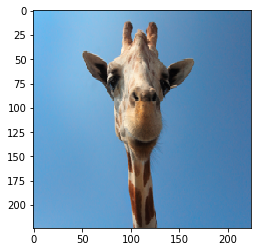

In [17]:
plt.imshow(img)

In [0]:
lab = rgb2lab(img.astype(np.uint8))

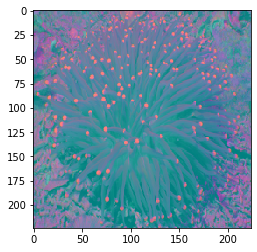

In [0]:
plt.imshow(lab)

In [0]:
img.shape

(224, 224, 3)

In [10]:
# 9.3.4 モデルの構築
from tensorflow.python.keras.layers import Conv2DTranspose

# Encoder
l1= tf.keras.layers.Conv2D(32, (3, 3), (1,1), activation='relu',  padding='same', input_shape=(224, 224, 1))

# 112x112
l2= tf.keras.layers.Conv2D(64, (3, 3), (2, 2), activation='relu', padding='same')

# 66x66
l3= tf.keras.layers.Conv2D(128, (3, 3), (2, 2), activation='relu', padding='same')

# 33x33
l4= tf.keras.layers.Conv2D(256, (3, 3), (2, 2), activation='relu', padding='same')

# Decoder
# 33x33
l5= tf.keras.layers.Conv2DTranspose(128, (3, 3), (2, 2), activation='relu', padding='same')

# 66x66
l6= tf.keras.layers.Conv2DTranspose(64, (3, 3), (2, 2), activation='relu', padding='same')

# 112x112
l7= tf.keras.layers.Conv2DTranspose(32, (3, 3), (2, 2), activation='relu', padding='same')

#224x224
l8= tf.keras.layers.Conv2D(2, (1, 1), (1, 1), activation='relu', padding='same')


autoencoder = tf.keras.Sequential()
autoencoder.add(l1)
autoencoder.add(l2)
autoencoder.add(l3)
autoencoder.add(l4)
autoencoder.add(l5)
autoencoder.add(l6)
autoencoder.add(l7)
autoencoder.add(l8)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 224, 224, 32)      1

In [0]:
# define generator
def generator_with_preprocessing(data_list, batch_size, shuffle=False, rescale=1.):
  while True:
    if shuffle:
      np.random.shuffle(data_list)
    for i in range(0, len(data_list), batch_size):
      batch_list = data_list[i:i+batch_size]
      batch_lab = get_lab_from_data_list(batch_list, rescale)
      batch_l = batch_lab[:, :, :, 0:1]
      batch_ab = batch_lab[:, :, :, 1:]
      yield (batch_l, batch_ab)
      

In [0]:
# call generator
batch_size = 10

train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True, rescale=255.)
valid_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True, rescale=255.)
test_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True, rescale=255.)

train_steps = math.ceil(len(train_lists)/batch_size)
valid_steps = math.ceil(len(valid_lists)/batch_size)
test_steps = math.ceil(len(test_lists)/batch_size)


In [15]:
# training
epochs = 100

lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/20) )

history = autoencoder.fit_generator(
    generator = train_gen,
    steps_per_epoch=train_steps,
    epochs = epochs,
    validation_data = valid_gen, 
    validation_steps = valid_steps, verbose = 1  
)


Epoch 1/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 2/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/100
64/64 [==============================] - 4s 66ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 4/100
64/64 [==============================] - 4s 65ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 5/100
64/64 [==============================] - 4s 66ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 6/100
64/64 [==============================] - 4s 65ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 7/100
64/64 [==============================] - 4s 64ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 8/100
64/64 [==============================] - 4s 65ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/100
64/64 [==============================] - 4s 65ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 10/100
64/64 [==============================] - 4s 66ms/step - loss: 0.0040 - val_loss: 0.0043

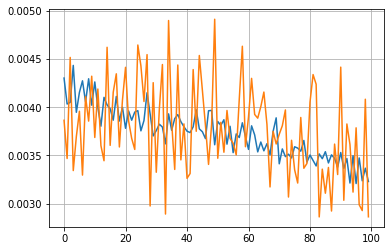

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.show()


In [22]:
# model prediction

preds = autoencoder.predict_generator(test_gen, steps=test_steps, verbose=1)

x_test = []
y_test = []

for i, (l, ab) in enumerate (generator_with_preprocessing(test_lists, batch_size, rescale=1.)):
  x_test.append(l)
  y_test.append(ab)
  if i==(test_steps - 1):
     break

x_test = np.vstack(x_test)
y_test = np.vstack(y_test)


8/8 [==============================] - 0s 42ms/step


In [28]:
print(x_test.shape)
print(preds.shape)

preds_int = np.clip(preds * 255, a_min=0, a_max=255).astype(np.uint8)
x_test_int = x_test.astype(np.uint8)

(80, 224, 224, 1)
(80, 224, 224, 2)


In [0]:


test_preds_lab = np.concatenate((x_test_int, preds_int), 3) #.astype(np.uint8)

test_preds_rgb = []

for i in range(test_preds_lab.shape[0]):
  preds_rgb = lab2rgb((test_preds_lab[i, :, :, :]))
  test_preds_rgb.append(preds_rgb)
test_preds_rgb = np.stack(test_preds_rgb)


-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------


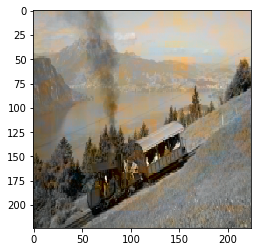

In [41]:
# output prediction image
#from IPython.display import display_png
#from PIL import Image, ImageOps

for i in range(test_preds_rgb.shape[0]):
  plt.imshow(test_preds_rgb[i]) #, c_maps='gray')
  #display_png(gray_img)
  plt.imshow(test_preds_rgb[i])
  print('-'*25)
  if i==20:
    break

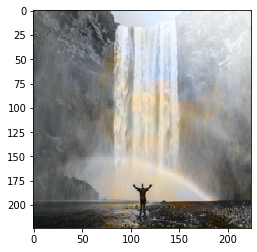

In [43]:
plt.imshow(test_preds_rgb[0]) #, c_maps='gray')
  #display_png(gray_img)
#  plt.imshow(test_preds_rgb[0])


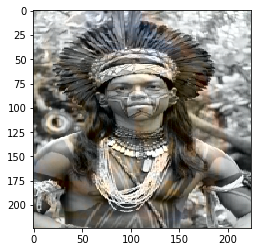

In [44]:
plt.imshow(test_preds_rgb[1]) #, c_maps='gray')


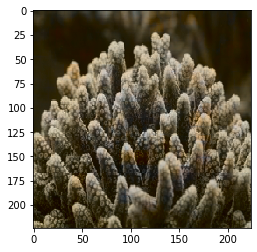

In [45]:
plt.imshow(test_preds_rgb[2]) #, c_maps='gray')


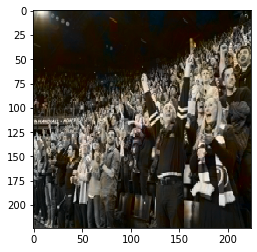

In [46]:
plt.imshow(test_preds_rgb[3]) #, c_maps='gray')

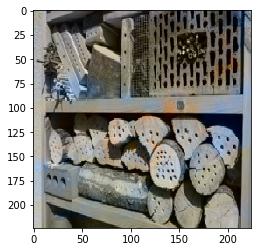

In [47]:
plt.imshow(test_preds_rgb[4]) #, c_maps='gray')

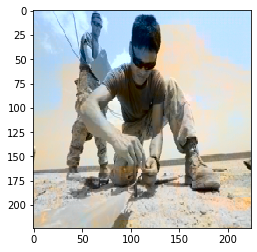

In [49]:
plt.imshow(test_preds_rgb[5]) #, c_maps='gray')

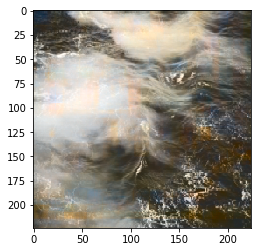

In [50]:
plt.imshow(test_preds_rgb[6]) #, c_maps='gray')

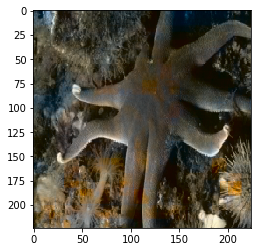

In [51]:
plt.imshow(test_preds_rgb[7]) #, c_maps='gray')

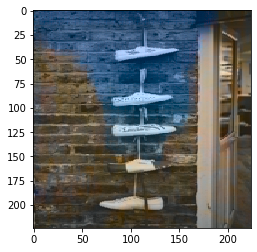

In [52]:
plt.imshow(test_preds_rgb[8]) #, c_maps='gray')

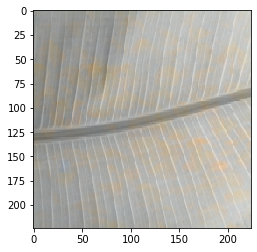

In [53]:
plt.imshow(test_preds_rgb[9]) #, c_maps='gray')

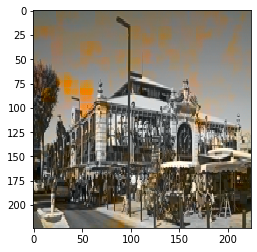

In [54]:
plt.imshow(test_preds_rgb[10]) #, c_maps='gray')